## Tests for *fpcross* module

> Cross approximation of the solution of the Fokker-Planck equation.

In [1]:
import sys

import numpy as np

sys.path.append('./../lib')
from intertrain import Intertrain
from solver import Solver

---
---

### Solution of the 1D Ornstein–Uhlenbeck process

> See detailed notes at the end of this file

In [2]:
A = 1.
m = 0. # Should be always zero!
s = 0.01

def func_f(x):
    return A * (-1. * x + m)

def func_f_der(x):
    return -1. * A * np.ones(x.shape)

def func_xm(t, x0):
    return np.exp(-1. * A * t) * x0
 
def func_xc(t):
    return (1. - np.exp(-2. * A * t)) / 2. / A

def func_r0(x):
    r = np.exp(-1. * (x - m)**2 / 2. / s) / np.sqrt(2. * np.pi * s)
    return r.reshape(-1)

def func_rx(x, t, x0):
    m = func_xm(t, x0)
    c = func_xc(t)
    r = np.exp(-0.5 * (x - m)**2 / c) / np.sqrt(2. * np.pi * c)
    return r.reshape(-1)

def func_rt(x, t):
    S = func_xc(t) + s * np.exp(-2. * A * t)
    r = np.exp(-1. * x**2 / 2. / S) / np.sqrt(2. * np.pi * S)
    return r.reshape(-1)

def func_rs(x):
    r = np.sqrt(A / np.pi) * np.exp(- A * x * x)
    return r.reshape(-1)

Solve: 100%|███████████████████| 9999/9999 [00:45<00:00, 221.17step/s]


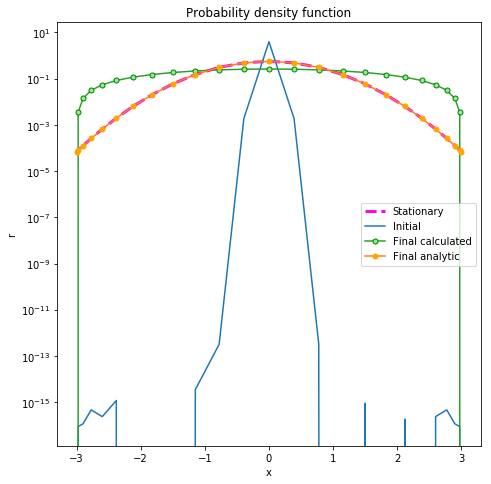

In [3]:
SL = Solver(d=1, with_tt=False)
SL.set_grid_t(10000, t_max=4.)
SL.set_grid_x(25)
SL.set_funcs(func_f, func_f_der, func_r0, func_rt, func_rs)
SL.prep()
SL.calc()
SL.plot()

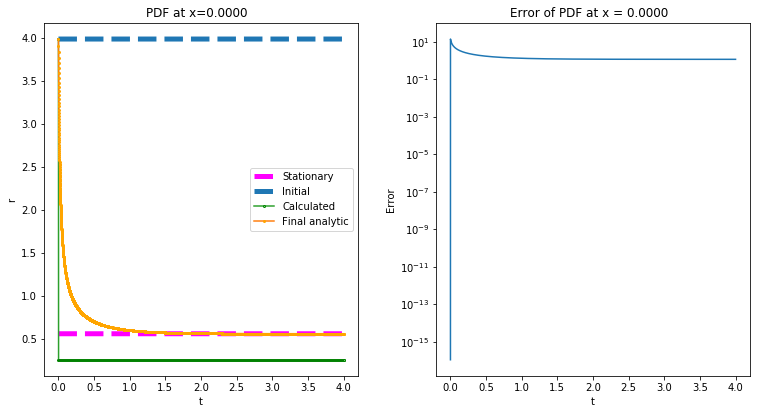

[3.9894228 0.2617884 0.2617884 ... 0.2617884 0.2617884 0.2617884]
[3.9894228  3.91347851 3.84176834 ... 0.56428249 0.56428242 0.56428235]


In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot(i):
    X = SL.IT.grid()
    x = X[:, i].reshape(-1, 1)
    T = SL.T

    fig = plt.figure(figsize=(10, 5))
    gs = mpl.gridspec.GridSpec(
        ncols=2, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
        wspace=0.25, hspace=0.3, width_ratios=[1, 1], height_ratios=[1]
    )

    ax = fig.add_subplot(gs[0, 0])
    # ax.semilogy()

    R = np.ones(len(T)) * func_rs(x)[0]
    ax.plot(T, R, '--', label='Stationary',
        linewidth=5, color='magenta')

    R = np.ones(len(T)) * SL.IT1.calc(x)
    ax.plot(T, R, '--', label='Initial',
        linewidth=5, color='tab:blue')

    R = [r[i] for r in SL.R]
    ax.plot(T, R, label='Calculated',
        color='tab:green', marker='o', markersize=2, markerfacecolor='lightgreen', markeredgecolor='g')

    R = [func_rt(x, t)[0] for t in T]
    ax.plot(T, R, label='Final analytic',
        color='tab:orange', marker='o', markersize=2, markerfacecolor='orange', markeredgecolor='orange')

    ax.set_title('PDF at x=%-8.4f'%x[0, 0])
    ax.set_xlabel('t')
    ax.set_ylabel('r')
    ax.legend(loc='best')

    ax = fig.add_subplot(gs[0, 1])
    ax.semilogy()
    
    R1 = np.array([r[i] for r in SL.R])
    R2 = np.array([func_rt(x, t)[0] for t in T])
    e = np.abs(R2 - R1) / np.abs(R1)
    
    ax.plot(T, e)
    ax.set_title('Error of PDF at x = %-8.4f'%x[0, 0])
    ax.set_xlabel('t')
    ax.set_ylabel('Error')

    plt.show()
    print(R1)
    print(R2)
    
plot(12)

In [8]:
#SL.anim(ffmpeg_path='./../tmp/ffmpeg', delt=200)

---
---

### Solution strategy

We are going to find probability density function (PDF) $\rho(x, t)$ for the spatial variable $x \in R^d$ which is the solution of the SDE with Brownian motion $\beta$ of dimension $q$
$$
dx = f(x, t) \, dt + S(x, t) \, d\beta,
\quad
d\beta \, d\beta^{\top} = Q dt,
\quad
x(0) \sim \rho(x, 0) = \rho_0 (x).
$$

It can be shown that the PDF at time $t$ ($t > 0$) is the solution of the Fokker-Planck equation
$$
\frac{\partial \rho(x, t)}{\partial t} =
    - \sum_{i=1}^d
        \frac{\partial}{\partial x_i}
        \left[ f_i(x, t) \rho(x, t) \right]
    + \sum_{i=1}^d \sum_{j=1}^d
        \frac{\partial^2}{\partial x_i \partial x_j}
        \left[ D_{ij}(x, t) \rho(x, t) \right],
\quad
\rho(x, 0) = \rho_0(x),
\quad
\rho(x, t) |_{x \rightarrow \infty} = 0,
$$
where
$$
D(x, t) = \frac{1}{2} S(x, t) Q S^{\top}(x, t).
$$

---
---

### Algorithm

> This is a draft of the algorithm. which is used in Solver module/class (Russian is used for simplicity).

**Задача:** найти PDF $\rho$ в момент времени $t$ на Чебышевской сетке из уравнений
$$
    dx = f(x, t) \, dt + d\beta,
    \quad
    \frac{\partial \rho}{\partial t} = \Delta \rho - div \left[ f(x, t) \rho \right],
    \quad
    \rho(x, 0) = \rho_0(x).
$$

**Нужно** передать в крест (tt-cross) функцию (step), которая вычисляет значения $\rho_{k+1}$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки. Это позволит проинтерполировать $\rho$ на $(k+1)$-ом шаге и перейти к следующему шагу, при этом предполагается, что интерполянт для $k$-ого шага уже известен.

> На нулевом шаге имеем $\rho_0(x)$, заданную как функцию от $x$ и можем построить интерполянт очевидным образом.

> Если не используем крест (работаем в полном numpy формате), то $X$ - это полный набор точек Чебышевской сетки (алгоритм при этом остается прежним).

> Алгоритм расписан для splitting схемы первого порядка, поэтому для решения ОДЕ можем использовать метод Эйлера без потери точности.

**Работа функции step(X, I)**

> X - произвольный набор точек Чебышевской сетки (ndarray [dims, pois] of float)

> I - набор индексов узлов сетки, соответствующий точкам X (ndarray [dims, pois] of int)

**1** Найти прообразы $\widehat{X}$ (соответствуют предыдущему $k$-ому шагу) для заданного набора точек $X$ Чебышевской сетки, которые приводили бы траекторию детерминированного уравнения ($\beta = 0$) в точки $X$ на $(k+1)$-ом шаге, интегрируя назад уравнение
$$
    \frac{\partial \, x}{\partial \, t} = f(x, t),
    \quad
    x_{k+1} = X,
    \quad
    x_{k} = \widehat{X} = ?,
$$
используя формулу Эйлера
$$
    \widehat{X} = X - h \cdot f(X, t_{k+1}).
$$

**2** Используя известный интерполянт на $k$-ом шаге, вычислить значения PDF $\widehat{\rho}$ в точках $\widehat{X}$.

**3** Положить нулевое значение для $\widehat{\rho}$ в тех точках из $\widehat{X}$, которые оказались вне пределов интерполяции.

**4** Решить PDE с однородными граничными условиями Дирихле для $(k+1)$-ого шага
$$
    \frac{\partial v}{\partial t} = \Delta v,
    \quad
    v_{k} = \widehat{\rho},
    \quad
    v_{k+1} = v = ?,
$$
используя дифференциальную матрицу Чебышева
$$
v = e^h \left( e^D \otimes \ldots \otimes e^D \right) \widehat{\rho},
$$

**5** Решить ODE для $k+1$-ого шага
$$
    \frac{\partial \, \log{w}}{\partial \, t} = -tr \left[ f_x(x, t) \right],
    \quad
    w_{k} = v,
    \quad
    w_{k+1} = w = ?,
$$
используя формулу Эйлера
$$
    \log{w} =
        \log{v} -
        h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k+1}) \right],
$$
или
$$
    w = \left(
        1 - h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k+1}) \right]
    \right) v.
$$

**6** Вернуть значение $w$ как приближение $\rho(x)$ в заданном (произвольном) наборе точек $X$ Чебышевской сетки на $(k+1)$-ом шаге.

**Примечание**

В качестве итоговой формулы (первого порядка точности) для вычисления значения $\rho$ на $(k+1)$-ом временном шаге в заданном (произвольном) наборе точек $X$ Чебышевской сетки по известному интерполянту для $\rho$ на $k$-ом шаге получили

$$
    \rho_{k+1}(X) =
        \left(
            1 - h \cdot tr \left[ \frac{\partial \, f}{\partial \, x}(\widehat{X}, t_{k+1}) \right]
        \right)
        e^h \left( e^D \otimes \ldots \otimes e^D \right)
        \rho_{k}(\widehat{X}),
    \quad
    \widehat{X} = X - h \cdot f(X, t_{k+1}).
$$

---
---

### Solution of the multivariate Ornstein–Uhlenbeck process

Let
$$
    f(x, t) \equiv A \left( \mu - x(t) \right),
    \quad
    S(x, t) \equiv S,
$$
then we come to the multivariate Ornstein–Uhlenbeck process
$$
    d \, x(t) = A \left( \mu - x(t) \right) d \, t + S d \, \beta(t),
$$
where

- $x \in R^d$ is a stochastic process;

- $\beta \in R^q$ is a Brownian motion;

- $\mu \in R^{d}$ is the long-term mean;

- $A \in R^{d \times d}$ is the velocity (invertible real matrix);

- $S \in R^{d \times q}$ are the friction coefficients (positive real matrix).

It can be shown (see [Alternative way to derive the distribution of the multivariate Ornstein–Uhlenbeck process](https://advancesindifferenceequations.springeropen.com/articles/10.1186/s13662-019-2214-1)) that

- Mean vector
$
    M(t, x_0) = e^{-A t} x_0 + \left( I - e^{-A t} \right) \mu
$;

- Covariance matrix
$
    \Sigma(t) = \int_0^t e^{A (s-t)} S S^T e^{A^T (s-t)} d \, s
$;

- Transitional PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{ | 2 \pi \Sigma(t) | }}
        exp \left[
            -\frac{1}{2} (x - M(t, x_0))^T \Sigma^{-1}(t) (x - M(t, x_0))
        \right]
$.

- The (multivariate) Ornstein–Uhlenbeck process, at any time, is a (multivariate) normal random variable.

- The Ornstein–Uhlenbeck process is mean-reverting (the solution tends to its long-term mean $\mu$ as time $t$ tends to infinity) if all eigenvalues of $A$ are positive (if $A > 0$ in the one dimensional case).

---

#### Solution of the 1D Ornstein–Uhlenbeck process

Let $\mu \equiv 0$ and $S \equiv 1$, then we have

- Mean value
$
    M(t, x_0) = e^{-A t} x_0
$;

- Covariance matrix
$
    \Sigma(t) = \frac{1 - e^{-2 A t}}{2 A} 
$;

- Transition PDF
$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        exp \left[
            -\frac{(x - M(t, x_0))^2}{2 \Sigma(t)}
        \right] =  
            \sqrt{
                \frac{A}{\pi \left( 1 - e^{-2 A t} \right)}
            }
            e^{\frac
                {-A \left( x - x_0 e^{-A t} \right)^2}
                {1 - e^{-2 A t}}
            }
$.

- Stationary PDF ($t \rightarrow \infty$)
$
    \rho_{\infty}(x) =  
        \sqrt{
            \frac{A}{\pi}
        }
        e^{-A x^2}
$.

- PDF
$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}
$  for initial condition
$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]}
$
(see proof below).

---

#### Proof of the formula for PDF of the 1D Ornstein–Uhlenbeck process

Let calculate PDF $\rho(x, t)$ at time $t$ in some spatial point $x$ using transition PDF $\rho(x, t, x_0)$
$$
    \rho(x, t, x_0) =
        \frac{1}{\sqrt{2 \pi \Sigma(t)}}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}
        \right]},
$$
and fixed initial condition
$$
    \rho_0(x) =
        \frac{1}{\sqrt{2 \pi s}}
        \exp{\left[
            -\frac{x^2}{2 s}
        \right]},
$$
from equation
$$
    \rho(x, t) = \int_{-\infty}^{\infty}
        \rho(x, t, x_0) \rho_0(x_0) \, d x_0.
$$

We have
$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{(x - e^{-A t} x_0)^2}{2 \Sigma(t)}  -\frac{x_0^2}{2 s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) = \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}\int_{-\infty}^{\infty}
        \exp{\left[
            -\frac{s (x - e^{-A t} x_0)^2 + \Sigma(t) x_0^2}{2 \Sigma(t) s}
        \right]}
        \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                \frac{- s e^{-2 A t} x_0^2 + 2 s x e^{-A t} x_0 - \Sigma(t) x_0^2}{2 \Sigma(t) s}
            \right]}
            \, d x_0,
$$

$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \int_{-\infty}^{\infty}
            \exp{\left[
                - \frac{s e^{-2 A t} + \Sigma(t)}{2 \Sigma(t) s} x_0^2
                + \frac{x e^{-A t}}{\Sigma(t)} x_0
            \right]}
            \, d x_0,
$$

Since
$$
    \int_{-\infty}^{\infty} e^{-a x^2 + b x} \, d x =
        \sqrt{\frac{\pi}{a}} e^{\frac{b^2}{4a}},
    \quad
    a > 0,
$$

we come to
$$
    \rho(x, t) =
        \frac{1}{\sqrt{4 \pi^2 \Sigma(t) s}}
        \exp{\left[
            -\frac{x^2}{2 \Sigma(t)}
        \right]}
        \sqrt{\frac{2 \pi \Sigma(t) s}{s e^{-2 A t} + \Sigma(t)}}
        \exp{\left[
            \frac{2 \Sigma(t) s x^2 e^{-2 A t}}{4 \Sigma^2(t) (s e^{-2 A t} + \Sigma(t))}
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s x^2 e^{-2 A t}
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            -
            \frac
                {
                    x^2
                }
                {
                    2 \Sigma(t)
                }
        \right]},
$$

$$
    \rho(x, t) =
        \sqrt{
            \frac
                {
                    1
                }
                {
                    2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        }
        \exp{\left[
            \frac
                {
                    s e^{-2 A t} - s e^{-2 A t} - \Sigma(t)
                }
                {
                    2 \Sigma(t) \left( s e^{-2 A t} + \Sigma(t) \right)
                }
            x^2
        \right]},
$$

$$
    \rho(x, t) =
        \frac
            {
                1
            }
            {
                \sqrt{2 \pi \left( \Sigma(t) + s e^{-2 A t} \right)}
            }
        \exp{\left[
            - \frac
                {
                    x^2
                }
                {
                    2 \left( \Sigma(t) + s e^{-2 A t} \right)
                }
        \right]}.
$$

---
---

### TMP

---

#### Solution of the 1D analytic example (draft)

Let consider a model equation

$$
\frac{\partial \, \rho}{\partial \, t} =
    \Delta \rho(x, t) - \frac{\partial}{\partial \, x} \left f(x, t) \rho(x, t) \right),
\quad
x \in [-3, 3],
\quad
\rho(-\infty, t) = 0,
\quad
\rho(\infty, t) = 0,
\quad
\rho(x, 0) = \sin{(\pi x + \phi)},
$$
with known exact solution
$$
\rho(x, t) = \sin{(\pi x + \phi)} e^{-\pi^2t}.
$$

We can solve it for the time $t$ using uniform time grid with step $h$ and iterations
$$
u_{k+1}(x) = e^{h \cdot D_2} u_{k}(x),
\quad
k = 0, 1, \ldots, \frac{t}{h} - 1.
$$
where $u_{0}(x)$ is known initial condition.